In [5]:
#Libraries
import holidays
import seaborn as sns
import plotly.express as px
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
import builtins
import plotly.graph_objects as go
from itertools import combinations
from mpl_toolkits.mplot3d import Axes3D

#Spark Libraries
from pyspark import SparkContext
from pyspark.ml.feature import PCA
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.sql.types import BooleanType
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
from sklearn.ensemble import IsolationForest
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
file_path = '/content/drive/MyDrive/Progetto Distributed/DDAM Group 2/credit_card_transaction_train.csv'  # Sostituisci con il percorso esatto

In [8]:
colors = {
    "Blue": "#1f77b4",
    "Green": "#2ca02c",
    "Red": "#d62728",
    "Grey": "#7f7f7f",
}

In [9]:
sc = SparkContext(appName="SPARK-BASICS", master="local[*]")
spark = SparkSession.builder.appName("MyApp").getOrCreate()

In [10]:
file_path = '/content/drive/MyDrive/Progetto Distributed/DDAM Group 2/credit_card_transaction_train.csv'  # Sostituisci con il percorso esatto
df = spark.read.csv(file_path, header=True, inferSchema=True)

**Missing values; Columns Pre-processing, Duplicates**

In [11]:
# Replace 'dob' with 'age'
df = df.withColumn('age', (year(current_date()) - year(col('dob'))))
# Replace gender M == 0; F == 1
df = df.withColumn('gender', when(col('gender') == 'M', '0').when(col('gender') == 'F', '1'))
df = df.drop('dob')
# Split the trans_date_trans_time in
df = df.withColumn('year', year(col('trans_date_trans_time')))
df = df.withColumn('month', month(col('trans_date_trans_time')))
df = df.withColumn('day', dayofmonth(col('trans_date_trans_time')))
df = df.withColumn('hour', hour(col('trans_date_trans_time')))
df = df.withColumn('minute', minute(col('trans_date_trans_time')))
df = df.withColumn('second', second(col('trans_date_trans_time')))
df = df.drop('trans_date_trans_time')
df = df.drop("unix_time", "first", "last", "zip_merchant")
df = df.withColumn("merchant", regexp_replace("merchant", "^fraud_", ""))

In [12]:
# Step 1: Create a broadcast variable for U.S. holidays
years = df.select("year").distinct().rdd.flatMap(lambda x: x).collect()
us_holidays = holidays.US(years=years)
broadcast_holidays = sc.broadcast(us_holidays)

# Step 2: Define a function to check if a date (year, month, day) is a holiday
def is_holiday(year, month, day):
    try:
        date_str = f"{year:04d}-{month:02d}-{day:02d}"
        return date_str in broadcast_holidays.value
    except:
        return False

is_holiday_udf = udf(is_holiday, BooleanType())
df = df.withColumn('is_holiday',is_holiday_udf(col('year'), col('month'), col('day')))
df = df.withColumn('is_holiday', when(col('is_holiday') == 'True', '0').when(col('is_holiday') == 'False', '1'))

In [13]:
# Calculate the number of transactions per credit card
no_transactions_by_cc = df.groupBy('cc_num').agg(count('*').alias('num_of_transactions'))
df = df.join(no_transactions_by_cc, on='cc_num', how='left')
df = df.withColumn('daily_tran', round((col('num_of_transactions')/537),2))
df = df.drop('num_of_transactions')
# avg daily spent
avg_spent_by_cc = df.groupBy('cc_num').agg(sum('amt').alias('sum_amt'))
avg_spent_by_cc = avg_spent_by_cc.withColumn('daily_avg_spent', round((col('sum_amt')/537),2)) #537 days considered in the DF
avg_spent_by_cc = avg_spent_by_cc.drop('sum_amt')
df = df.join(avg_spent_by_cc, on='cc_num', how='left')

In [14]:
# total spent by category (for each card)
df_total_spent = df.groupBy('cc_num', 'category').agg(round(sum('amt'), 2).alias('total_spent'))
categories = df.select('category').distinct().rdd.flatMap(lambda x: x).collect()
df_total_spent = df_total_spent.groupBy('cc_num').pivot('category').agg(first('total_spent'))
df = df.join(df_total_spent, on='cc_num', how='left')
df = df.drop('total_spent')

# Frequency encoding + smoothing

Instead of one-hot encoding I replaced **categories** and **states** with the smoothed frequence, based on their presence in the dataset. The smoothing params is usefule because otherwise, if one class is more represented than another this may lead to unintended behaviours.

In [15]:
category_counts = df.groupBy("category").count()
df = df.join(category_counts, on="category", how="left")

total_count = df.count()
num_categories = df.select("category").distinct().count()

alpha = 1  # Smoothing parameter (hyperparam)

df = df.withColumn("cat_enc", round((df['count'] + alpha) / (total_count + alpha * num_categories), 5)) #cat_enc: category encoded

df = df.drop('count')

category_counts = df.groupBy("state").count()
df = df.join(category_counts, on="state", how="left")

num_categories = df.select("state").distinct().count()


df = df.withColumn("st_enc", round((df["count"] + alpha) / (total_count + alpha * num_categories), 5)) #st_enc: state encoded
df = df.drop('count')

Clustering may involves different level of granularity: clustering of customers and clustering of transactions

In [16]:
df_cu = df.groupBy('cc_num').count()
df_cu = df_cu.drop('count')

In [17]:
df_for_customers = df.select('cc_num',
          'age',
          'gender',
          'st_enc',
          'zip', 'lat','long',
 'city_pop','daily_tran',
 'daily_avg_spent',
 'travel',
 'misc_net',
 'grocery_pos',
 'kids_pets',
 'shopping_net',
 'grocery_net',
 'food_dining',
 'gas_transport',
 'personal_care',
 'health_fitness',
 'entertainment',
 'home',
 'misc_pos',
 'shopping_pos')

df_for_customers = df_for_customers.dropDuplicates(['cc_num'])
df_num_trans_in_holidays = df.filter('is_holiday = 1').groupBy('cc_num').count().alias('count')
df_num_trans_in_holidays = df_num_trans_in_holidays.withColumnRenamed('count', 'num_trans_in_holidays')
df_cu = df_cu.join(df_for_customers, on="cc_num", how="left")
df_cu = df_cu.join(df_num_trans_in_holidays, on="cc_num", how="left")

# CORRELATION MATRIX

In [18]:
# Compute correlation matrix
numeric_cols = ['amt', 'age', 'daily_tran', 'daily_avg_spent']
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
vector_df = assembler.transform(df).select("features")

matrix = Correlation.corr(vector_df, "features").head()[0].toArray()
print("Correlation Matrix:")
print(matrix)

# Removing variables with high correlation
high_corr_indices = []
threshold = 0.9
for i in range(len(matrix)):
    for j in range(i + 1, len(matrix)):
        if builtins.abs(float(matrix[i][j])) > threshold:
            high_corr_indices.append(j)

columns_to_remove = [numeric_cols[i] for i in high_corr_indices]
df = df.drop(*columns_to_remove)
print(f"Removed columns: {columns_to_remove}")
df.show(5)


Correlation Matrix:
[[ 1.         -0.00974821 -0.01043722  0.03202919]
 [-0.00974821  1.         -0.34960753 -0.34147919]
 [-0.01043722 -0.34960753  1.          0.86881683]
 [ 0.03202919 -0.34147919  0.86881683  1.        ]]
Removed columns: []
+-----+-------------+----------------+----------+--------------------+------+------+--------------------+--------------+-----+-------+---------+--------+--------------------+--------------------+------------------+------------------+--------+-------------+---+----+-----+---+----+------+------+----------+----------+---------------+-------------+-----------+-------------+-----------+-----------+--------------+--------+---------+--------+--------+-------------+------------+------------+--------+-------+-------+
|state|     category|          cc_num|Unnamed: 0|            merchant|   amt|gender|              street|          city|  zip|    lat|     long|city_pop|                 job|           trans_num|         merch_lat|        merch_long|is_fraud

# ISOLATION FOREST

In [19]:
numeric_cols = ['amt', 'age', 'daily_tran', 'daily_avg_spent']

assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
data = assembler.transform(df)



pandas_df = data.select(numeric_cols).toPandas()
iso_forest = IsolationForest(contamination=0.1, random_state=42)
outliers = iso_forest.fit_predict(pandas_df)
pandas_df['outlier'] = outliers

# Filter out detected outliers
pandas_df = pandas_df[pandas_df['outlier'] == 1].drop(columns=['outlier'])
df = spark.createDataFrame(pandas_df)
df.show(5)


+------+---+----------+---------------+
|   amt|age|daily_tran|daily_avg_spent|
+------+---+----------+---------------+
|198.39| 50|      1.94|         182.67|
| 43.83| 38|      1.89|         110.25|
|111.81| 46|      2.81|         271.43|
| 49.58| 36|       1.9|         121.14|
| 81.72| 36|       1.9|         121.14|
+------+---+----------+---------------+
only showing top 5 rows



In [20]:
df.count()

1167010

# SSE E SILHOUETTE

In [21]:
numeric_cols = ['amt', 'age', 'daily_tran', 'daily_avg_spent']

# Assembla le caratteristiche in un unico vettore
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
data = assembler.transform(df).select('features')

data.cache()

# Define the k
k_values = list(range(2, 11))
sse = []
silhouette_scores = []

evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')

for k in k_values:
    kmeans = KMeans(k=k, seed=1, featuresCol='features')
    model = kmeans.fit(data)

    wssse = model.summary.trainingCost
    sse.append(wssse)
    print(f"Il SSE per k={k} è {wssse}")

    predictions = model.transform(data)

    silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette)
    print(f"Il coefficiente di silhouette per k={k} è {silhouette}")

# Plot the graph
df_results = pd.DataFrame({
    'Numero di Cluster (k)': k_values,
    'SSE': sse,
    'Silhouette Score': silhouette_scores
})

fig_sse = px.line(
    df_results,
    x='Numero di Cluster (k)',
    y='SSE',
    title='SSE per diversi valori di k',
    markers=True,
    template='plotly_white'
)
fig_sse.show()

fig_silhouette = px.line(
    df_results,
    x='Numero di Cluster (k)',
    y='Silhouette Score',
    title='Coefficiente di Silhouette per diversi valori di k',
    markers=True,
    template='plotly_white'
)
fig_silhouette.show()


Il SSE per k=2 è 7040099566.852129
Il coefficiente di silhouette per k=2 è 0.6372647427747299
Il SSE per k=3 è 4888010976.627247
Il coefficiente di silhouette per k=3 è 0.5223618897018154
Il SSE per k=4 è 3804768561.608033
Il coefficiente di silhouette per k=4 è 0.540636004586163
Il SSE per k=5 è 2998099744.637742
Il coefficiente di silhouette per k=5 è 0.5383373677007305
Il SSE per k=6 è 2580118421.392893
Il coefficiente di silhouette per k=6 è 0.48019283523706413
Il SSE per k=7 è 2360445058.733945
Il coefficiente di silhouette per k=7 è 0.444495250363717
Il SSE per k=8 è 2069843871.7804413
Il coefficiente di silhouette per k=8 è 0.47855727110431734
Il SSE per k=9 è 1796257557.3289828
Il coefficiente di silhouette per k=9 è 0.4837770267901363
Il SSE per k=10 è 1677976262.5662465
Il coefficiente di silhouette per k=10 è 0.4841063695960515


# K-means

Silhouette Score: 0.5383373677007305
Cluster Centers:
[ 51.63106258  41.12164448   4.50956171 314.45083272]
[133.97092957  53.5594393    3.16939445 213.16436333]
[ 41.05340435  55.29259921   1.7687138  114.17479004]
[ 29.00675298  54.11735259   3.36399797 212.47173272]
[ 48.9251788   42.24979967   5.2360499  452.01434339]


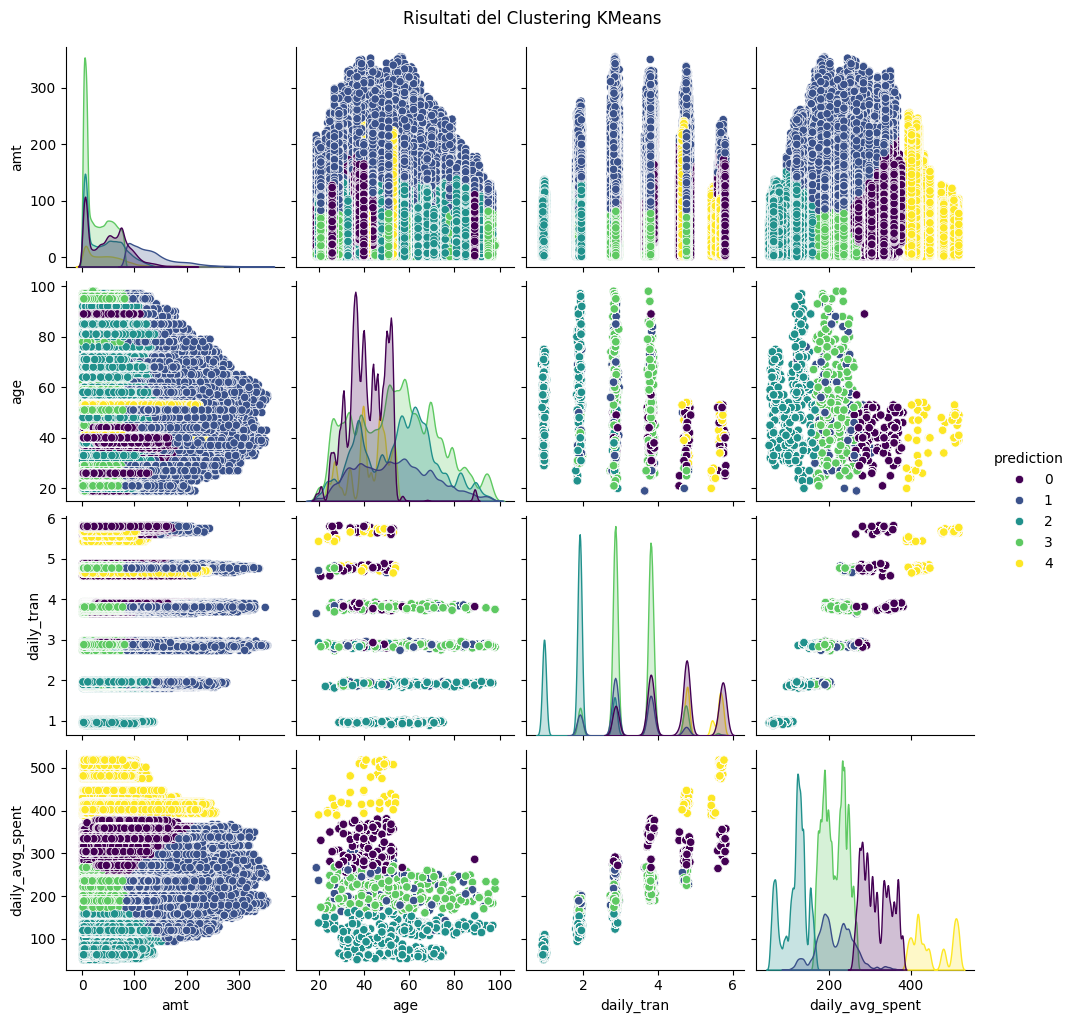

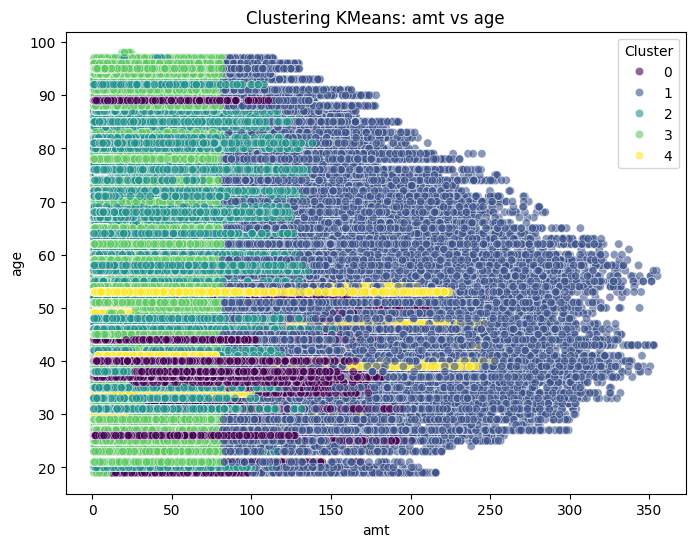

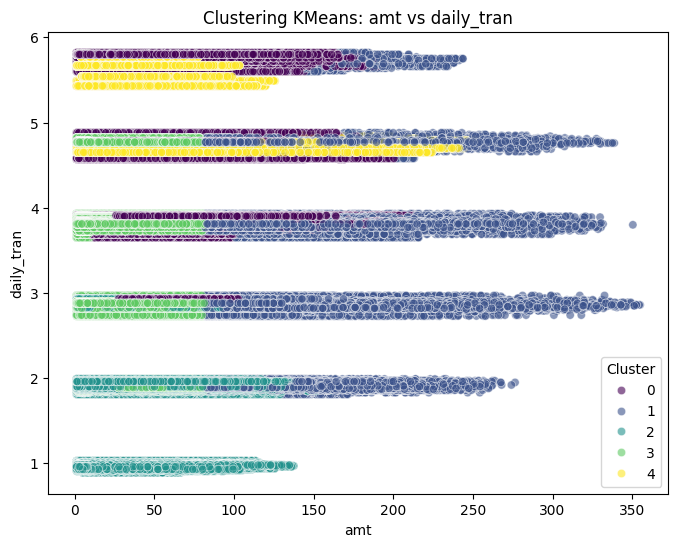

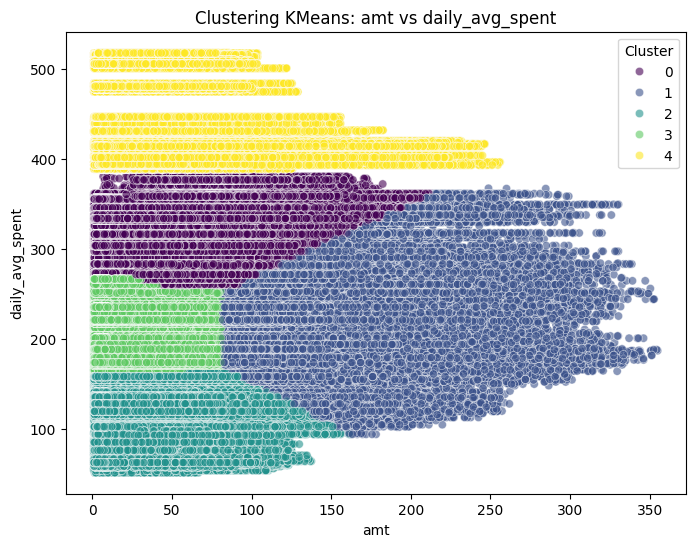

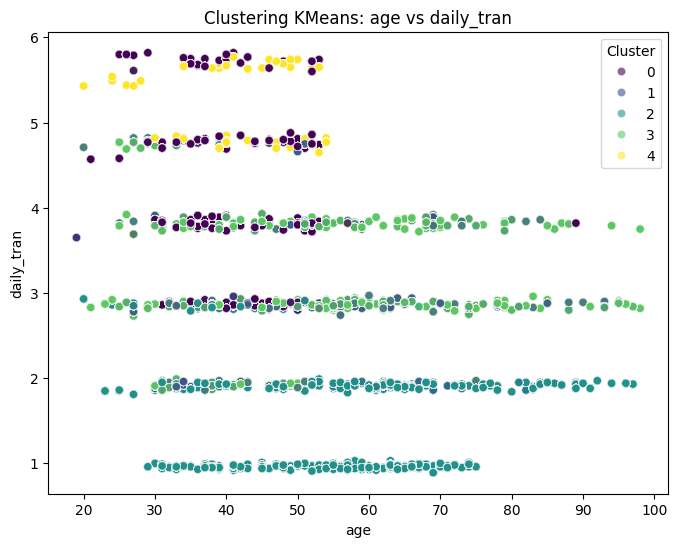

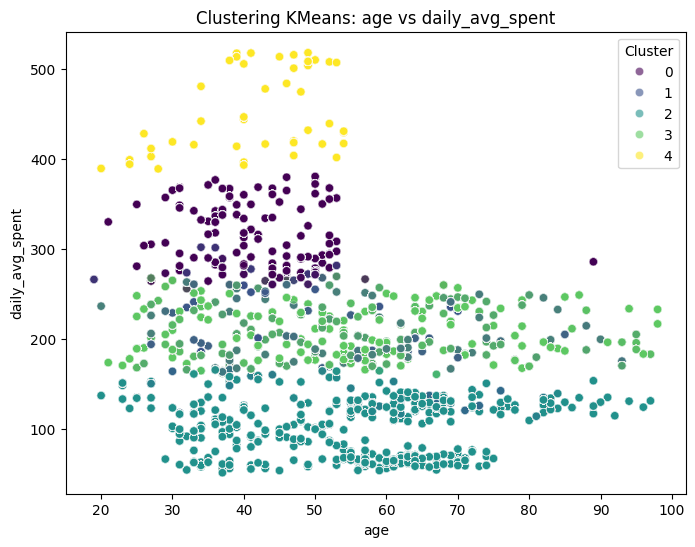

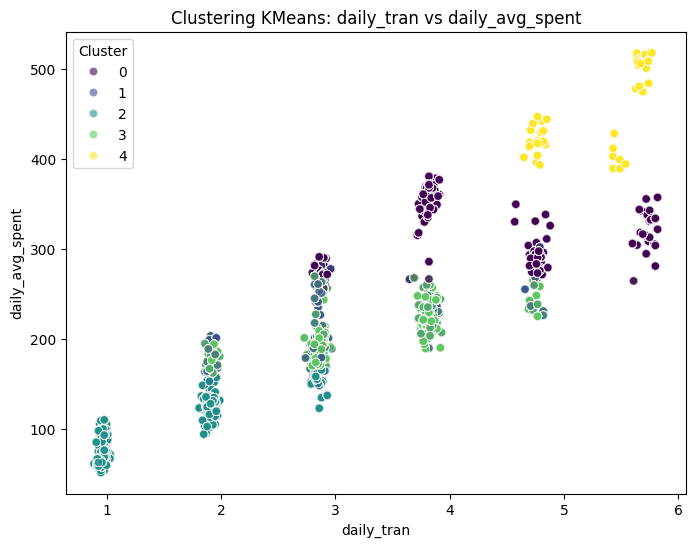

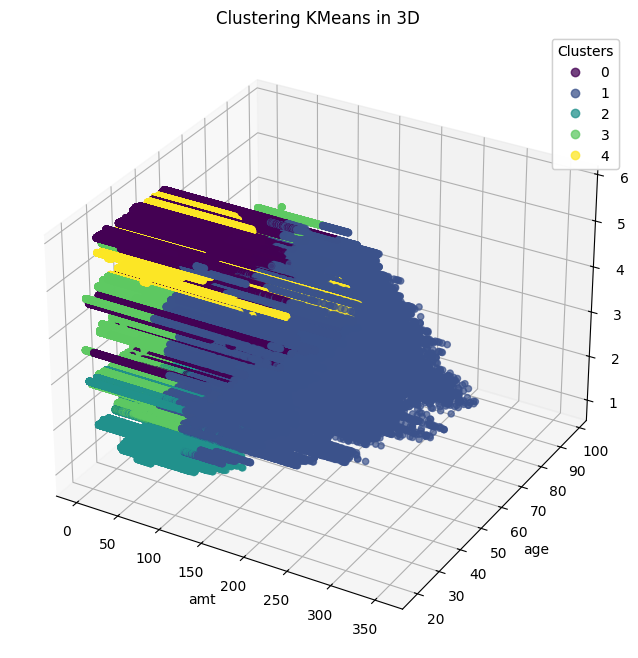

In [22]:
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
data = assembler.transform(df)

# Clustering KMeans
kmeans = KMeans(k=5, seed=1, featuresCol='features', predictionCol='prediction')
model = kmeans.fit(data)

predictions = model.transform(data)

evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette Score: {silhouette}")

print("Cluster Centers:")
for center in model.clusterCenters():
    print(center)


pandas_df = predictions.select(numeric_cols + ['prediction']).toPandas()

sns.pairplot(pandas_df, vars=numeric_cols, hue='prediction', palette='viridis', diag_kind='kde')
plt.suptitle('Risultati del Clustering KMeans', y=1.02)
plt.show()

column_pairs = list(combinations(numeric_cols, 2))

for col_x, col_y in column_pairs:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=pandas_df, x=col_x, y=col_y, hue='prediction', palette='viridis', alpha=0.6)
    plt.title(f'Clustering KMeans: {col_x} vs {col_y}')
    plt.xlabel(col_x)
    plt.ylabel(col_y)
    plt.legend(title='Cluster')
    plt.show()


selected_features = ['amt', 'age', 'daily_tran']

x = pandas_df[selected_features[0]]
y = pandas_df[selected_features[1]]
z = pandas_df[selected_features[2]]
clusters = pandas_df['prediction']

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(x, y, z, c=clusters, cmap='viridis', alpha=0.7)

ax.set_title('Clustering KMeans in 3D')
ax.set_xlabel(selected_features[0])
ax.set_ylabel(selected_features[1])
ax.set_zlabel(selected_features[2])

legend = ax.legend(*scatter.legend_elements(), title="Clusters", loc="upper right")
ax.add_artist(legend)

plt.show()
